# Deep Music Genre

In [1]:
import os
import _pickle as pickle

import IPython
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from keras import optimizers
from keras.utils.vis_utils import model_to_dot

from models import resnet

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


## Visualizing and preprocessing

We already have the preprocessed songs as melspectograms (see scripts/generate_data.py). Let's load them and see one for each genre.

In [2]:
GTZAN_ROOT = 'datasets/genres'
GTZAN_GENRES = [f for f in os.listdir(GTZAN_ROOT)
                if os.path.isdir(os.path.join(GTZAN_ROOT, f))]
CLASSES = len(GTZAN_GENRES)

In [3]:
with open(os.path.join(GTZAN_ROOT, 'data.pickle'), 'rb') as f:
    X, y = pickle.load(f)
    
print(X.shape)
print(y.shape)

(1000, 128, 647)
(1000, 10)


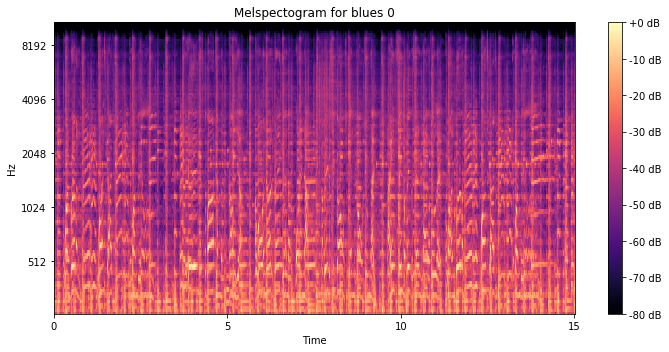

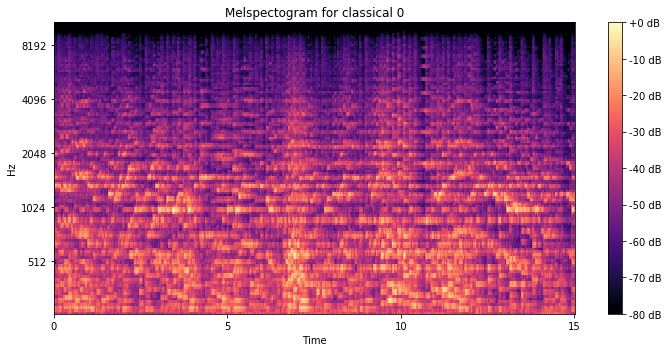

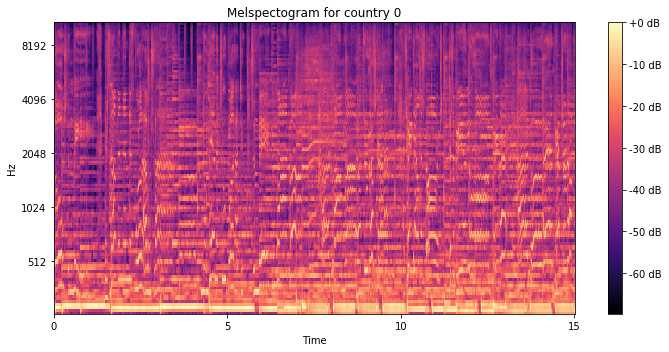

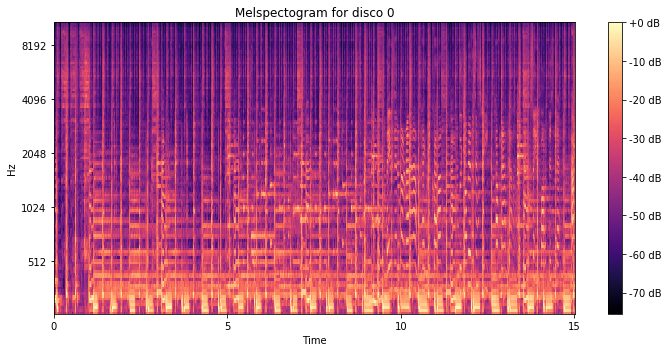

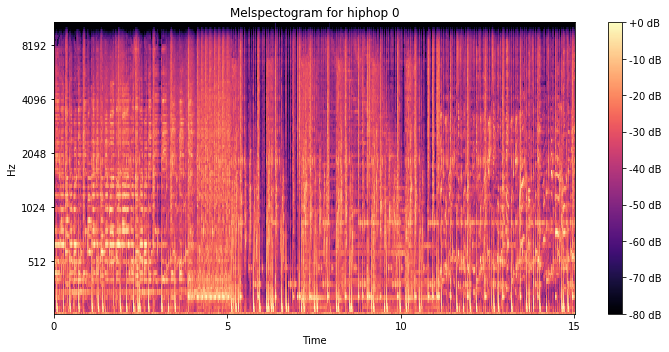

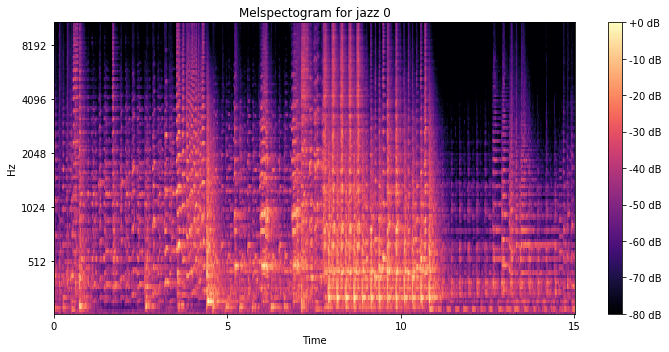

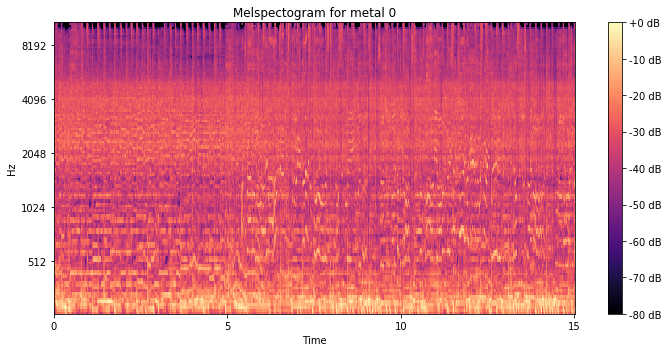

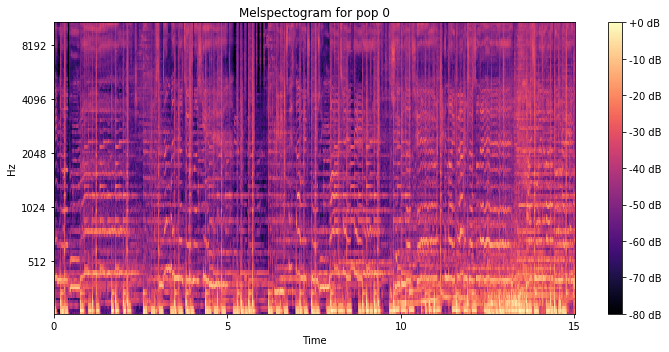

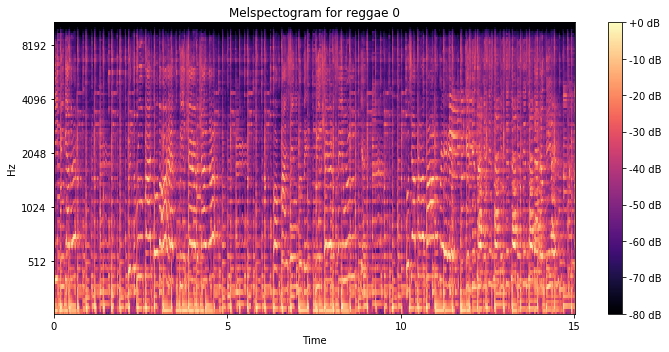

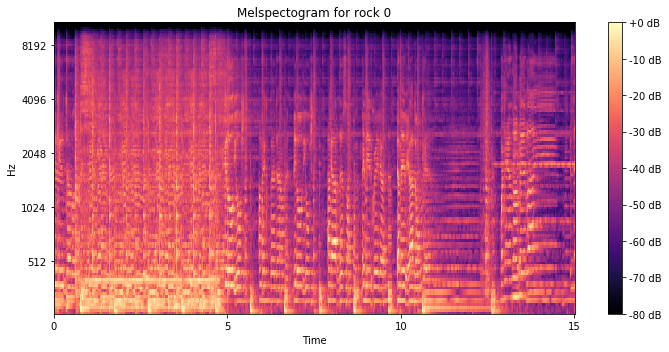

In [4]:
for i, genre in enumerate(GTZAN_GENRES):
    x = X[i*100, :, :]
    plt.figure(figsize=(10, 5))
    librosa.display.specshow(x, y_axis='mel', x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Melspectogram for ' + genre + ' 0')
    plt.tight_layout()

Let's split the data into validation, test and train sets. Then we'll also shuffle it.

In [5]:
N_TRAIN = 800
N_TEST = 200
WIDTH, HEIGHT = X[0].shape

indices = [np.random.permutation(np.arange(100)) for _ in range(CLASSES)]
indices = [[x + i*100 for x in xs] for i, xs in enumerate(indices)]
train_slice = slice(0, N_TRAIN//CLASSES)
test_slice = slice(N_TRAIN//CLASSES, None)
indices_train = np.array([xs[train_slice] for xs in indices]).reshape(-1)
indices_test = np.array([xs[test_slice] for xs in indices]).reshape(-1)

data = {
    'X_train': X[indices_train, :, :].reshape((N_TRAIN, WIDTH, HEIGHT, 1)),
    'y_train': y[indices_train, :],
    'X_test': X[indices_test, :, :].reshape((N_TEST, WIDTH, HEIGHT, 1)),
    'y_test': y[indices_test, :]
}

print('TRAIN: X = {0}, y = {1}'.format(data['X_train'].shape, data['y_train'].shape))
print('TEST: X = {0}, y = {1}'.format(data['X_test'].shape, data['y_test'].shape))

TRAIN: X = (800, 128, 647, 1), y = (800, 10)
TEST: X = (200, 128, 647, 1), y = (200, 10)


Now let's center the data around the mean, and split it into test, train and validation sets.

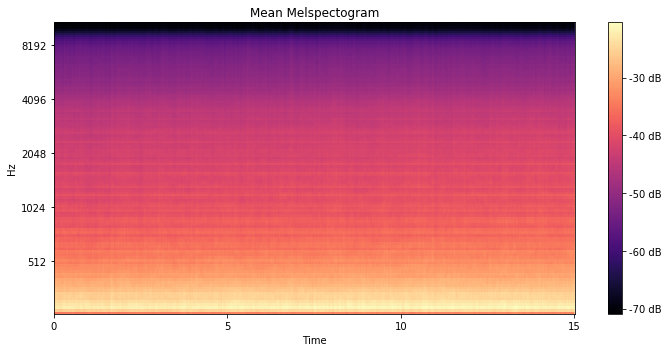

In [6]:
mean_spectogram = np.mean(data['X_train'], axis=0)
plt.figure(figsize=(10, 5))
librosa.display.specshow(mean_spectogram.reshape((WIDTH, HEIGHT)), y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mean Melspectogram')
plt.tight_layout()

In [ ]:
data['X_test'] -= mean_spectogram
data['X_train'] -= mean_spectogram

## Training the model

We'll be using a Resnet model with 5 Identity residual units per residual block (as described in [Identity Mappings in Deep Residual Networks](https://arxiv.org/pdf/1603.05027.pdf)).

In [ ]:
model = resnet.get(data['X_train'][0].shape, CLASSES, resnet.IdentityResidualUnit, [5,5,5])
IPython.display.SVG(model_to_dot(model).create(prog='dot', format='svg'))

Now let's train our model using Adam.

In [ ]:
BATCH_SIZE = 32
EPOCHS = 100

optimizer = optimizers.Adam(lr=1e-3)
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'])
model.fit(data['X_train'], data['y_train'],
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_split=0.25,
          verbose=1)